In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
train_users = pd.read_csv('../data/raw/train_users.csv')
test_users = pd.read_csv('../data/raw/test_users.csv')

In [6]:
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

In [9]:
users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105


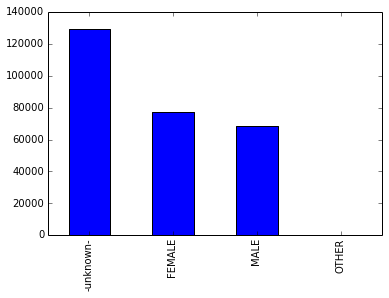

In [48]:
users.gender.astype('category').value_counts().plot(kind='bar')

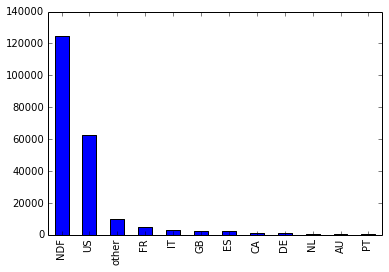

In [46]:
users.country_destination.astype('category').value_counts().plot(kind='bar')

In [84]:
# Preprocess this data
users.loc[users.age > 500, 'age'] = 2015 - users.age 
users.loc[users.age > 90, 'age'] = np.nan
users.loc[users.age < 13, 'age'] = np.nan

119783 155764


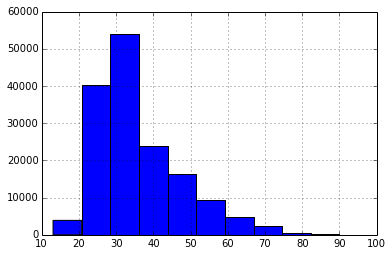

In [85]:
users.age.hist()
print users.age.isnull().sum(), users.age.count()

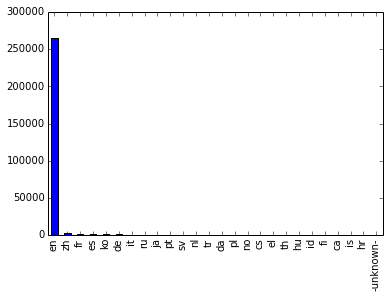

In [97]:
users.language.astype('category').value_counts().plot(kind='bar')

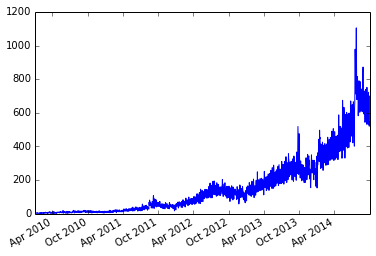

In [101]:
users.date_account_created.astype('datetime64').value_counts().plot()